# DSM Assignment 3
Please pay attention to the following instructions:
1. Please follow carefully the steps outlined in the assignment. If you cannot solve an exercise and this hinders continuing with subsequent exercises, try to find a way to work around it and give a clear explanation for the solution you have chosen.
2. Submit your work in the form of a Jupyter notebook via Canvas, before the deadline. Your notebook should not give errors when executed with `Run All`.

## Part 0: importing the relevant libraries

**Exercise 1:** import all the libraries you are using in this notebook.

In [1]:
import os, pickle
import numpy as np

from sklearn import datasets
from sklearn.datasets import fetch_openml

from logistic_regression_src import ClassifierBase, plot_digits_sample

## Part 1: binary logistic regression (only examples, no exercises)
In this section, we will train a binary logistic regression model based on a simplified version of the MNIST dataset. In the cell below, this dataset is imported and visualized. It consists of 360 images (resolution 8x8), of which 178 are handwritten zeros and the other 182 are handwritten ones. The images are stored in `X`, while the targets (a 1 or 0) are stored in `y`.

Total number of observations: 360
Number of observations of class 0: 178
Number of observations of class 1: 182


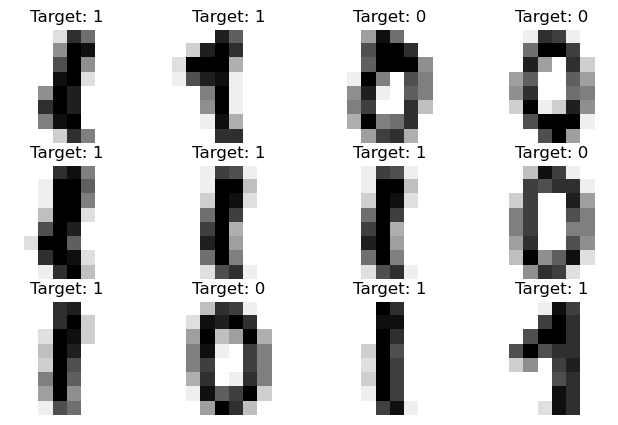

In [2]:
# DO NOT CHANGE THIS CELL!!! #
digits = datasets.load_digits()
X = digits.images[np.logical_or(digits.target == 0, digits.target == 1)]
y = digits.target[np.logical_or(digits.target == 0, digits.target == 1)].reshape(-1, 1)
N = len(y)
K = np.unique(y).shape[0]
digits.target_names = np.unique(y).sort()

print(f"Total number of observations: {N}")
for k in range(K):
    print(f"Number of observations of class {k}: {np.sum(y == k)}")

plot_digits_sample(X, y)

**Example:** the goal of this example is to train a logistic regression model for the binary classification task of the simplified MNIST dataset above. Each image can be considered as a point in a 8x8=64 dimensional feature space. The target variable is binary: 0 or 1.

Write a class `BinaryLogisticRegressionClassifier`, with parental class `ClassifierBase` that does this. Use stochastic gradient descent for training and use as the loss function the negative log likelihood. At initialization, set `learning_rate`, `batch_size` and `epochs` to default values 0.0001, 20 and 3, respectively.

Include in the `fit` method a `verbose` keyword. If `True`, after each epoch the training error should be printed.

In [3]:
class BinaryLogisticRegressionClassifier(ClassifierBase):
    """
    Binary logistic regression classifier using stochastic gradient descent.

    This class implements a binary logistic regression model for classification tasks,
    using negative log likelihood as the loss function and SGD for optimization.

    Parameters
    ----------
    learning_rate : float, default=0.0001
        Learning rate for gradient descent.
    batch_size : int, default=20
        Number of samples per batch for SGD.
    epochs : int, default=3
        Number of passes over the training data.
    """

    def __init__(self, learning_rate=0.0001, batch_size=20, epochs=3):
        """
        Initialize the classifier.
        """
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.beta = None
        self.K = None

    def _flatten(self, X):
        """
        Flatten input images to 2D array.

        Returns
        -------
        np.ndarray
            Flattened data of shape (n_samples, n_features).
        """
        return X.reshape(X.shape[0], -1)
    
    def _batchify(self, X, y):
        """
        Split data into batches.

        Returns
        -------
        tuple
            Batched X and y.
        """
        n_batches = X.shape[0] // self.batch_size
        X = X[:n_batches*self.batch_size].reshape(n_batches, self.batch_size, *X.shape[1:])
        y = y[:n_batches*self.batch_size].reshape(n_batches, self.batch_size, 1)
        return X, y
    
    def _sigmoid(self, x):
        """
        Numerically stable sigmoid function.
        """
        out = np.where(
            x >= 0,
            1 / (1 + np.exp(-x)),
            np.exp(x) / (1 + np.exp(x))
        )
        return out.reshape(-1, 1)

    def _compute_logits(self, X_flat):
        """
        Compute logits for input data.
        """
        X_flat = np.hstack((np.ones((X_flat.shape[0], 1)), X_flat))
        return X_flat @ self.beta, X_flat

    def _compute_gradient_loss(self, X, y):
        """
        Compute gradient of the loss function.
        """
        X_flat = self._flatten(X)
        logits, X_flat_with_bias = self._compute_logits(X_flat)
        p = self._sigmoid(logits)
        grad = (p - y).flatten() @ X_flat_with_bias / X_flat.shape[0]
        return grad

    def fit(self, X, y, initialize_beta=True, verbose=False):
        """
        Fit the logistic regression model.

        Parameters
        ----------
        X : np.ndarray
            Training data.
        y : np.ndarray
            Training labels.
        initialize_beta : bool, default=True
            Whether to re-initialize model parameters.
        verbose : bool, default=False
            If True, print training accuracy after each epoch.
        """
        self.K = np.unique(y).shape[0]
        X_batched, y_batched = self._batchify(X, y)
        n_features = np.prod(X_batched.shape[2:]).item()
        if initialize_beta or self.beta is None:
            self.beta = np.random.randn(n_features + 1) * 0.01  # Small random initialization
        if verbose == True:
            print(f"Epoch {0}/{self.epochs}, Training accuracy: {self.score(X, y):.2%}")
        for epoch in range(self.epochs):
            for j, X_batch in enumerate(X_batched):
                y_batch = y_batched[j]
                gradient = self._compute_gradient_loss(X_batch, y_batch)
                self.beta -= self.learning_rate * gradient

            if verbose == True:
                print(f"Epoch {epoch+1}/{self.epochs}, Training accuracy: {self.score(X, y):.2%}")

    def predict(self, X):
        """
        Predict class labels for samples in X.

        Returns
        -------
        np.ndarray
            Predicted class labels.
        """
        logits, _ = self._compute_logits(self._flatten(X))
        p = self._sigmoid(logits)
        y_pred = (p > 0.5).astype(int)
        return y_pred

**Example:** run the cell below. It trains a logistic regression model and computes its accuracy on the training set, if you correctly did the previous exercise. If `verbose=True` it also reports the training accuracy while training.

Play with the values of `learning_rate`, `batch_size` and `epochs`. By doing so, try to get a training accuracy of near 100%.

In [4]:
model = BinaryLogisticRegressionClassifier(learning_rate=0.0001, batch_size=20, epochs=3)
model.fit(X, y, verbose=True)

Epoch 0/3, Training accuracy: 66.39%
Epoch 1/3, Training accuracy: 96.94%
Epoch 2/3, Training accuracy: 97.78%
Epoch 3/3, Training accuracy: 98.61%


**Example:** run the cell below. It uses cross-validation to estimate model performance of the `BinaryLogisticRegressionClassifier` model.

In [5]:
model = BinaryLogisticRegressionClassifier(learning_rate=0.01, batch_size=20, epochs=3)
model.cross_validation(X, y, K_cv=5, runs=10)

(0.9983333333333334, 0.0006447649527488834)

**Example:** run the cell below. It computes the confusion matrix using cross-validation.

In [6]:
model.confusion_matrix(X, y, K_cv=5, runs=10, class_labels=digits.target_names)

Actual class:,0,1
Predicted class:,,
0,1.0,0.0
1,0.0,1.0


## Part 2: logistic regression (non-binary labels)
We now re-load the dataset and include all possible 10 handwritten digits.

Total number of observations: 1797
Number of observations of class 0: 178
Number of observations of class 1: 182
Number of observations of class 2: 177
Number of observations of class 3: 183
Number of observations of class 4: 181
Number of observations of class 5: 182
Number of observations of class 6: 181
Number of observations of class 7: 179
Number of observations of class 8: 174
Number of observations of class 9: 180


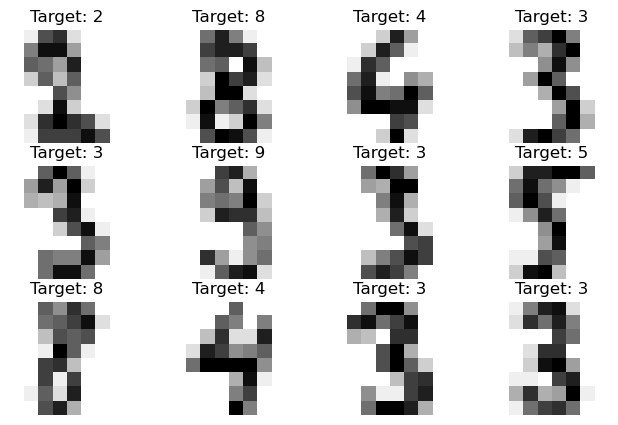

In [7]:
# DO NOT CHANGE THIS CELL!!! #
digits = datasets.load_digits()
X = digits.images
y = digits.target.reshape(-1, 1)
N = len(y)
K = np.unique(y).shape[0]

print(f"Total number of observations: {N}")
for k in range(K):
    print(f"Number of observations of class {k}: {np.sum(y == k)}")
    
plot_digits_sample(X, y)

**Exercise 2:** create a new class `LogisticRegressionClassifier`, similar to the class `BinaryLogisticRegressionClassifier` defined above, that performs logistic regression on the MNIST dataset loaded in the previous cell. Since this is not a binary classification task, you have to work with a one-hot encoded target variable and a softmax function (instead of a sigmoid function).

Use comments inside the code to clearly indicate where and how this class differs from the class `BinaryLogisticRegressionClassifier` defined above.

In [8]:
class LogisticRegressionClassifier(ClassifierBase):
    """
    Multi-class logistic regression classifier using stochastic gradient descent.

    This class implements a multi-class logistic regression model for classification tasks,
    using negative log likelihood as the loss function and SGD for optimization.
    
    Key differences from BinaryLogisticRegressionClassifier:
    - Uses one-hot encoding for multi-class targets instead of binary labels
    - Implements softmax function instead of sigmoid for multi-class probabilities
    - Beta parameter matrix has shape (n_features + 1, n_classes) instead of vector
    - Gradient computation handles multiple classes simultaneously

    Parameters (stay the same) 
    ----------
    learning_rate : float, default=0.0001
        Learning rate for gradient descent.
    batch_size : int, default=20
        Number of samples per batch for SGD.
    epochs : int, default=3
        Number of passes over the training data.
    """

    def __init__(self, learning_rate=0.0001, batch_size=20, epochs=3):
        """
        Initialize the classifier.
        """
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.beta = None
        self.K = None

    def _flatten(self, X):
        """
        Flatten input images to 2D array.

        Returns
        -------
        np.ndarray
            Flattened data of shape (n_samples, n_features).
        """
        return X.reshape(X.shape[0], -1)
    
    def _batchify(self, X, y):
        """
        Split data into batches.

        Returns
        -------
        tuple
            Batched X and y.
        """
        n_batches = X.shape[0] // self.batch_size
        X = X[:n_batches*self.batch_size].reshape(n_batches, self.batch_size, *X.shape[1:])
        y = y[:n_batches*self.batch_size].reshape(n_batches, self.batch_size, -1)
        return X, y
    
    def _one_hot_encode(self, y):
        """
        Convert labels to one-hot encoded format.

        This differs from the binary case by using K classes
        instead of binary classification.
        
        Parameters
        ----------
        y : np.ndarray
            Label array of shape (n_samples, 1)
            
        Returns
        -------
        np.ndarray
            One-hot encoded labels of shape (n_samples, n_classes)
        """
        n_samples = y.shape[0]
        y_one_hot = np.zeros((n_samples, self.K))
        y_one_hot[np.arange(n_samples), y.flatten()] = 1
        return y_one_hot
    
    def _softmax(self, logits):
        """
        Numerically stable softmax function for multi-class probabilities.
        
        This replaces sigmoid function to handle multiple classes
        instead of binary classification.
        
        Parameters
        ----------
        logits : np.ndarray
            Logits of shape (n_samples, n_classes)
            
        Returns
        -------
        np.ndarray
            Softmax probabilities of shape (n_samples, n_classes)
        """
        # Subtract max for numerical stability
        exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

    def _compute_logits(self, X_flat):
        """
        Compute logits for input data.
        
        This returns logits matrix of shape (n_samples, n_classes)
        instead of vector for binary classification.
        """
        X_flat = np.hstack((np.ones((X_flat.shape[0], 1)), X_flat))
        return X_flat @ self.beta, X_flat

    def _compute_gradient_loss(self, X, y):
        """
        Compute gradient of the loss function for multi-class classification.

        This computes gradient for multi-class setting using one-hot
        encoded targets and softmax probabilities instead of binary sigmoid.
        """
        X_flat = self._flatten(X)
        logits, X_flat_with_bias = self._compute_logits(X_flat)
        p = self._softmax(logits)  # Shape: (batch_size, K)
        y_one_hot = self._one_hot_encode(y)  # Shape: (batch_size, K)
        
        # Gradient computation for multi-class: X^T @ (p - y_one_hot) / batch_size
        grad = X_flat_with_bias.T @ (p - y_one_hot) / X_flat.shape[0]  # Shape: (n_features + 1, K)
        return grad

    def fit(self, X, y, initialize_beta=True, verbose=False):
        """
        Fit the logistic regression model.

        Parameters
        ----------
        X : np.ndarray
            Training data.
        y : np.ndarray
            Training labels.
        initialize_beta : bool, default=True
            Whether to re-initialize model parameters.
        verbose : bool, default=False
            If True, print training accuracy after each epoch.
        """
        self.K = np.unique(y).shape[0]
        X_batched, y_batched = self._batchify(X, y)
        n_features = np.prod(X_batched.shape[2:]).item()
        
        # Difference: Beta is now a matrix of shape (n_features + 1, K) instead of vector
        if initialize_beta or self.beta is None:
            self.beta = np.random.randn(n_features + 1, self.K) * 0.01
            
        if verbose == True:
            print(f"Epoch {0}/{self.epochs}, Training accuracy: {self.score(X, y):.2%}")
            
        for epoch in range(self.epochs):
            for j, X_batch in enumerate(X_batched):
                y_batch = y_batched[j]
                gradient = self._compute_gradient_loss(X_batch, y_batch)
                self.beta -= self.learning_rate * gradient

            if verbose == True:
                print(f"Epoch {epoch+1}/{self.epochs}, Training accuracy: {self.score(X, y):.2%}")

    def predict(self, X):
        """
        Predict class labels for samples in X.

        This uses argmax of softmax probabilities to get predicted class
        instead of thresholding sigmoid at 0.5 for binary classification.

        Returns
        -------
        np.ndarray
            Predicted class labels of shape (n_samples, 1).
        """
        logits, _ = self._compute_logits(self._flatten(X))
        p = self._softmax(logits)  # Shape: (n_samples, K)
        y_pred = np.argmax(p, axis=1).reshape(-1, 1)  # Shape: (n_samples, 1)
        return y_pred

**Exercise 3:** use the cell below to show that the class `LogisticRegressionClassifier` works as desired. In particular, show that
* it learns to predict the training data during training.
* it also learns to predict out-of-sample data (using cross-validation).
* it also learns to predict out-of-sample data (using a confusion matrix).

Write in a markdown cell explicitly which of the 10 digits is the hardest to predict.

In [9]:
# LogisticRegressionClassifier with training progress
np.random.seed(9)
model = LogisticRegressionClassifier(learning_rate=0.01, batch_size=20, epochs=10)
model.fit(X, y, verbose=True)

print(f"\nFinal training accuracy: {model.score(X, y):.2%}")

# Model performance with out of sample data 
np.random.seed(9)
model = LogisticRegressionClassifier(learning_rate=0.01, batch_size=20, epochs=10)
model.cross_validation(X, y, K_cv=5, runs=10)

print(f"\nModel Performance with cross validation: {model.score(X, y):.2%}")

# Model performance with confusion matrix
np.random.seed(9)
model.confusion_matrix(X, y, K_cv=5, runs=10, class_labels=digits.target_names)


Epoch 0/10, Training accuracy: 7.90%
Epoch 1/10, Training accuracy: 92.82%
Epoch 2/10, Training accuracy: 93.60%
Epoch 3/10, Training accuracy: 93.99%
Epoch 4/10, Training accuracy: 93.99%
Epoch 5/10, Training accuracy: 94.05%
Epoch 6/10, Training accuracy: 94.32%
Epoch 7/10, Training accuracy: 94.71%
Epoch 8/10, Training accuracy: 95.27%
Epoch 9/10, Training accuracy: 95.38%
Epoch 10/10, Training accuracy: 95.55%

Final training accuracy: 95.55%

Model Performance with cross validation: 95.10%


Actual class:,0,1,2,3,4,5,6,7,8,9
Predicted class:,,,,,,,,,,
0,1.0,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.01,0.00
1,0.0,0.98,0.02,0.00,0.05,0.01,0.02,0.00,0.15,0.01
2,0.0,0.00,0.95,0.00,0.00,0.01,0.00,0.00,0.01,0.00
3,0.0,0.00,0.03,0.97,0.00,0.01,0.00,0.01,0.08,0.01
4,0.0,0.00,0.00,0.00,0.90,0.00,0.00,0.00,0.00,0.00
5,0.0,0.00,0.00,0.00,0.00,0.91,0.00,0.00,0.01,0.01
6,0.0,0.00,0.00,0.00,0.03,0.01,0.97,0.00,0.01,0.00
7,0.0,0.00,0.00,0.00,0.01,0.00,0.00,0.97,0.01,0.00
8,0.0,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.67,0.00


From the confusion matrix it can be seen that the number 8 is the most difficult to predict, in fact it has the lowest accuracy with only 67% being correctly classified. 

**Exercise 4:** the dataset we have worked with so far is a simplification of the original MNIST dataset, as the resolution is 8x8 instead of 28x28. Use the cell below to download and import the original MNIST dataset. This can be done, for example, with the `sklear` package. The data must be saved in a folder called `data`, which must be created if it does not exist yet. 

Note that this dataset has a default training set (the first 60000 observations) and test set (the last 10000 observations). At the end of the cell, organize the data in objects `X_train`, `y_train`, `X_test`, `y_test`, such that these objects have the same dimensional structure as used earlier in this notebook.

In [10]:
# original MNIST dataset
mnist = fetch_openml('mnist_784', version=1, cache=True, data_home='data')

# Extract features and targets
X_full = mnist.data.values
y_full = mnist.target.values.astype(int)

# Split into training and test sets (first 60000 for training, last 10000 for test)
X_train = X_full[:60000].reshape(60000, 28, 28)  # Shape: (60000, 28, 28)
y_train = y_full[:60000].reshape(-1, 1)          # Shape: (60000, 1)
X_test = X_full[60000:].reshape(10000, 28, 28)   # Shape: (10000, 28, 28)
y_test = y_full[60000:].reshape(-1, 1)           # Shape: (10000, 1)

print(f"Training set: X_train shape {X_train.shape}, y_train shape {y_train.shape}")
print(f"Test set: X_test shape {X_test.shape}, y_test shape {y_test.shape}")
print(f"Number of unique classes: {len(np.unique(y_train))}")

# Display class distribution in training set
print("\nTraining set class distribution:")
print(f"Total training observations: {len(y_train)}")
print(f"Total test observations: {len(y_test)}")
for k in range(10):
    print(f"Class {k}: {np.sum(y_train == k)} samples")


Training set: X_train shape (60000, 28, 28), y_train shape (60000, 1)
Test set: X_test shape (10000, 28, 28), y_test shape (10000, 1)
Number of unique classes: 10

Training set class distribution:
Total training observations: 60000
Total test observations: 10000
Class 0: 5923 samples
Class 1: 6742 samples
Class 2: 5958 samples
Class 3: 6131 samples
Class 4: 5842 samples
Class 5: 5421 samples
Class 6: 5918 samples
Class 7: 6265 samples
Class 8: 5851 samples
Class 9: 5949 samples


**Exercise 5:** show that the training accuracy of a logistic regression classifier on the MNIST dataset typically converges to about 88%. Furthermore, show that this is also the case for the test accuracy. (Hint: `ClassifierBase` has a built-in method called `score`).

In [11]:
# Train model on MNIST training set and evaluate on both training and test sets
np.random.seed(9)
model = LogisticRegressionClassifier(learning_rate=0.01, batch_size=100, epochs=30)
model.fit(X_train, y_train, verbose=True)

# Calculate training and test accuracy
train_accuracy = model.score(X_train, y_train)
test_accuracy = model.score(X_test, y_test)

print(f"\nFinal training accuracy: {train_accuracy:.2%}")
print(f"Final test accuracy: {test_accuracy:.2%}")

Epoch 0/30, Training accuracy: 5.09%
Epoch 1/30, Training accuracy: 83.43%
Epoch 2/30, Training accuracy: 86.93%
Epoch 3/30, Training accuracy: 87.24%
Epoch 4/30, Training accuracy: 85.23%
Epoch 5/30, Training accuracy: 88.29%
Epoch 6/30, Training accuracy: 87.02%
Epoch 7/30, Training accuracy: 88.52%
Epoch 8/30, Training accuracy: 89.21%
Epoch 9/30, Training accuracy: 89.00%
Epoch 10/30, Training accuracy: 88.74%
Epoch 11/30, Training accuracy: 86.12%
Epoch 12/30, Training accuracy: 89.36%
Epoch 13/30, Training accuracy: 87.78%
Epoch 14/30, Training accuracy: 85.96%
Epoch 15/30, Training accuracy: 87.28%
Epoch 16/30, Training accuracy: 87.49%
Epoch 17/30, Training accuracy: 88.28%
Epoch 18/30, Training accuracy: 89.82%
Epoch 19/30, Training accuracy: 86.08%
Epoch 20/30, Training accuracy: 90.03%
Epoch 21/30, Training accuracy: 88.67%
Epoch 22/30, Training accuracy: 88.10%
Epoch 23/30, Training accuracy: 90.32%
Epoch 24/30, Training accuracy: 87.27%
Epoch 25/30, Training accuracy: 86.1

**Exercise 6:** use a single line of code to determine which of the 10 digest are the hardest to predict. Use the test set for this exercise.

In [12]:
# Hardest digit to predict is the lowest number on the diagonal in the confusion matrix 
hardest_digit = model.confusion_matrix(X_test, y_test, K_cv=5, runs=10, class_labels=digits.target_names).values.diagonal().argmin()
print(f"Hardest digit to predict: {hardest_digit}")

Hardest digit to predict: 8


## Part 3: modeling competition
This part of the assignment consists of a modeling competition. In the cell below a dataset `data_train` is loaded, consisting of 1000 independent observations with 2000-dimensional continuous input features `data_train.X` and a binary target variable `data_train.y`. It also contains another binary variable `data_train.a`.

Your goal is to use this data to train a model with the best generalization performance. This model uses the input features $X$ to predict the target variable $y.$ The additional label $a$ may not be used to predict $y.$ The names of the students with the 3 best performing models will be announced.

This part of the assignment consists of three subsections:
* *analysis*: in this subsection you should analyze the data and try different modeling techniques and compare them in the correct way. You can use as many cells (code, markdown) as you need. Make sure your analysis is structured logically. It should be readable like a report or essay.
* *best model*: based on your analysis in the previous subsection, you have identified a best model. This should be defined in the code cell of this subsection, in the form of a class called `Model`.
* *generalization performance*: in this subsection the generalization performance of your best model `Model` is assessed. This is done with a test set consisting of 1000 independent datapoints. Students do not have access to this test set. It is **important** to note that the test set is **not** drawn from the same distribution as the train set. One can partition the data in four subgroups: ($y=0, a=0$), ($y=0, a=1$), ($y=1, a=0$), ($y=1, a=1$). In the training set the occurrence frequency of the subgroups is unequal, while for the test set it is equal. On the other hand, the marginal distribution of $(X,y)$ is the same for both the training and test set. We call the relation between $y$ and $a$ a "spurious correlation". This means that predicting $y$ using $X$ for the test set can be learned with the training set, but it is important that the generalization performance is good for all subgroups.

Details of the modeling competition:
* you are only allowed to use methods that have been discussed in this course.
* the cell in the subsection *generalization performance* should **NOT** be changed!!! Not that if the test set file `data_test.pkl` is not available (which is the case for students), a file called `data_test_FAKE.pkl` is loaded instead. The data in this file has exactly the same structure as the data in `data_test.pkl`, but the actual numbers are completely random. You can use this file to test whether the cell in the subsection *generalization performance* runs without errors.

In [13]:
# DO NOT CHANGE THIS CELL!!! #
class DataSimple():
    """Simplified Data class without DGP reference, noise and masks."""
    
    def __init__(self, y: np.ndarray, a: np.ndarray, x: np.ndarray, random_state: int = None):
        """
        Initialize the DataSimple object.

        Args:
            y: Binary outcome variable
            a: Attribute variable
            x: Composite variable
            random_state: Seed for reproducibility
        """
        self.n = y.shape[0]
        self.y = y
        self.a = a
        self.X = x
        self.random_state = random_state

    def get_shapes(self) -> dict:
        """Return the shapes of y, a, and x."""
        return {
            'y_shape': self.y.shape,
            'a_shape': self.a.shape,
            'x_shape': self.X.shape
        }

with open('data/data_train.pkl', 'rb') as f:
    data_train = pickle.load(f)

#### Analysis
Use the space below for your analysis of this modeling problem. You can use as many cells (code, markdown) as you need. Make sure your analysis is structured logically. It should be readable like a report or essay.

In order to find the best model the following procedures will be implemented: 

1. Data Analysis and visualisation 
2. Model Evaluations 
    - Lasso Regression 
    - Ridge Regression 
    - PCA 
    - Logistic Regression 
    - Bayesian 
3. Some of the models will be combined using model averaging in order to improve robustness 

In [14]:
# Check shapes of training data
print("Data shapes:")
print(f"X shape: {data_train.X.shape}")
print(f"y shape: {data_train.y.shape}")
print(f"a shape: {data_train.a.shape}")

# Check correlation between y and a
correlation_ya = np.corrcoef(data_train.y.flatten(), data_train.a.flatten())[0, 1]
print(f"\nCorrelation between y and a: {correlation_ya:.4f}")

# Check class distributions
print(f"\nClass distribution for y:")
unique_y, counts_y = np.unique(data_train.y, return_counts=True)
for val, count in zip(unique_y, counts_y):
    print(f"y={val}: {count} samples ({count/len(data_train.y)*100:.1f}%)")

print(f"\nClass distribution for a:")
unique_a, counts_a = np.unique(data_train.a, return_counts=True)
for val, count in zip(unique_a, counts_a):
    print(f"a={val}: {count} samples ({count/len(data_train.a)*100:.1f}%)")

# Cross-tabulation of y and a
print(f"\nCross-tabulation of y and a:")
for y_val in unique_y:
    for a_val in unique_a:
        count = np.sum((data_train.y == y_val) & (data_train.a == a_val))
        print(f"y={y_val}, a={a_val}: {count} samples")

# Calculate mean and variance of X features
X_mean = np.mean(data_train.X, axis=0)
X_var = np.var(data_train.X, axis=0)

print(f"\nFeature statistics:")
print(f"Mean of means: {np.mean(X_mean):.4f}")
print(f"Mean of variances: {np.mean(X_var):.4f}")
print(f"Min feature mean: {np.min(X_mean):.4f}")
print(f"Max feature mean: {np.max(X_mean):.4f}")
print(f"Min feature variance: {np.min(X_var):.4f}")
print(f"Max feature variance: {np.max(X_var):.4f}")


Data shapes:
X shape: (1000, 2000)
y shape: (1000, 1)
a shape: (1000, 1)

Correlation between y and a: 0.8065

Class distribution for y:
y=0: 506 samples (50.6%)
y=1: 494 samples (49.4%)

Class distribution for a:
a=0: 525 samples (52.5%)
a=1: 475 samples (47.5%)

Cross-tabulation of y and a:
y=0, a=0: 467 samples
y=0, a=1: 39 samples
y=1, a=0: 58 samples
y=1, a=1: 436 samples

Feature statistics:
Mean of means: 0.0002
Mean of variances: 0.2643
Min feature mean: -0.0596
Max feature mean: 0.0562
Min feature variance: 0.2200
Max feature variance: 0.4077


From the above we can deduce that there is a strong correlation between y and a, in fact in the four subgroups, we can see that most of the samples have a = y. 

In [15]:
from sklearn.preprocessing import StandardScaler

# Standardize the features (mean=0, variance=1)

scaler = StandardScaler()
X_standardized = scaler.fit_transform(data_train.X)

# checking if the standarization worked
print(f"Original X statistics:")
print(f"Mean: {np.mean(data_train.X):.4f}")
print(f"Std: {np.std(data_train.X):.4f}")

print(f"\nStandardized X statistics:")
print(f"Mean: {np.mean(X_standardized):.4f}")
print(f"Std: {np.std(X_standardized):.4f}")

Original X statistics:
Mean: 0.0002
Std: 0.5144

Standardized X statistics:
Mean: 0.0000
Std: 1.0000


Since there is a correlation between a and y, and the test set has equal subgroup frequencies (unlike the training set as we've seen above), the following metrics will be compared for model evaluation: 

- worst group accuracy i.e. performance of the poorest performing subgroup 
- balanced group accuracy across all subgroups 

These will be determined using a class that uses cross validation on a model and presents these outputs for comparison reasons. 

In [16]:
from sklearn.model_selection import StratifiedKFold

def evaluate_model_with_subgroups(model_class, data, cv_folds=5, **model_kwargs):
    """
    Evaluate a model using cross-validation with subgroup-aware metrics.
    
    Parameters:
    -----------
    model_class : class
        The model class to evaluate
    data : DataSimple
        The data object containing X, y, and a
    cv_folds : int
        Number of CV folds
    **model_kwargs : dict
        Parameters to pass to model constructor
    
    Returns:
    --------
    dict : Results containing metrics
    """
    X = data.X
    y = data.y
    a = data.a
    
    # Create stratified folds ensuring all subgroups are represented
    composite_y = y.flatten() * 2 + a.flatten()  # Creates 4 unique labels for subgroups
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    
    fold_results = {
        'worst_group_acc': [],
        'balanced_group_acc': [],
        'overall_acc': []
    }
    
    for train_idx, val_idx in skf.split(X, composite_y):
        # Split data
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        a_train, a_val = a[train_idx], a[val_idx]
        
        # Create DataSimple objects for training and validation
        train_data = DataSimple(y_train, a_train, X_train)
        
        # Initialize and train model
        model = model_class(**model_kwargs)
        model.fit(train_data)
        
        # Get predictions on validation set
        y_pred = model.predict(X_val)
        
        # Calculate subgroup accuracies
        subgroup_accs = []
        for y_class in [0, 1]:
            for a_class in [0, 1]:
                mask = (y_val.flatten() == y_class) & (a_val.flatten() == a_class)
                if np.sum(mask) > 0:
                    acc = np.mean(y_pred[mask] == y_val[mask])
                    subgroup_accs.append(acc)
        
        # Store metrics for this fold
        if subgroup_accs:
            fold_results['worst_group_acc'].append(min(subgroup_accs))
            fold_results['balanced_group_acc'].append(np.mean(subgroup_accs))
            fold_results['overall_acc'].append(np.mean(y_pred.flatten() == y_val.flatten()))
    
    return {
        'worst_group_mean': np.mean(fold_results['worst_group_acc']),
        'worst_group_std': np.std(fold_results['worst_group_acc']),
        'balanced_group_mean': np.mean(fold_results['balanced_group_acc']),
        'balanced_group_std': np.std(fold_results['balanced_group_acc']),
        'overall_mean': np.mean(fold_results['overall_acc']),
        'overall_std': np.std(fold_results['overall_acc'])
    }

**1. Ridge Regression** 

In [17]:
class RidgeLogisticRegression():
    """
    Ridge Logistic Regression for binary classification with L2 regularization.
    """
    
    def __init__(self, alpha=1.0, learning_rate=0.01, max_iter=1000, tol=1e-6):
        self.alpha = alpha
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
        self.beta = None
        self.feature_mean = None
        self.feature_std = None
    
    def _sigmoid(self, z):
        """Numerically stable sigmoid function."""
        # Add clipping to prevent extreme values
        z = np.clip(z, -500, 500)
        return np.where(z >= 0, 
                       1 / (1 + np.exp(-z)), 
                       np.exp(z) / (1 + np.exp(z)))
    
    def fit(self, data):
        """Fit the ridge logistic regression model."""
        X = data.X
        y = data.y.flatten()
        
        # Standardize features
        self.feature_mean = np.mean(X, axis=0)
        self.feature_std = np.std(X, axis=0) + 1e-8
        X_std = (X - self.feature_mean) / self.feature_std
        
        # Add intercept term
        X_aug = np.hstack([np.ones((X_std.shape[0], 1)), X_std])
        n_features = X_aug.shape[1]
        
        # Initialize parameters (small random values often work better)
        self.beta = np.random.normal(0, 0.01, n_features)
        
        # Gradient descent with L2 regularization
        for iteration in range(self.max_iter):
            # Predictions
            z = X_aug @ self.beta
            p = self._sigmoid(z)
            
            # Gradient with L2 penalty (don't regularize intercept)
            gradient = X_aug.T @ (p - y) / len(y)
            gradient[1:] += self.alpha * self.beta[1:]  # L2 penalty for weights (not intercept)
            
            # Update parameters
            beta_old = self.beta.copy()
            self.beta -= self.learning_rate * gradient
            
            # Check convergence
            if np.linalg.norm(self.beta - beta_old) < self.tol:
                break
    
    def predict(self, X):
        """Predict binary labels."""
        X_std = (X - self.feature_mean) / self.feature_std
        X_aug = np.hstack([np.ones((X_std.shape[0], 1)), X_std])
        z = X_aug @ self.beta
        probabilities = self._sigmoid(z)
        predictions = (probabilities > 0.5).astype(int)
        return predictions.reshape(-1, 1)
    
    def predict_proba(self, X):
        """Predict class probabilities."""
        X_std = (X - self.feature_mean) / self.feature_std
        X_aug = np.hstack([np.ones((X_std.shape[0], 1)), X_std])
        z = X_aug @ self.beta
        return self._sigmoid(z)

**2. Lasso Regression**

In [18]:
class LassoLogisticRegression():
    """
    Lasso Logistic Regression for binary classification with L1 regularization.
    """
    
    def __init__(self, alpha=1.0, learning_rate=0.01, max_iter=1000, tol=1e-6):
        self.alpha = alpha
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
        self.beta = None
        self.feature_mean = None
        self.feature_std = None
    
    def _sigmoid(self, z):
        """Numerically stable sigmoid function."""
        # Add clipping to prevent extreme values
        z = np.clip(z, -500, 500)
        return np.where(z >= 0, 
                       1 / (1 + np.exp(-z)), 
                       np.exp(z) / (1 + np.exp(z)))
    
    def _soft_thresholding(self, x, threshold):
        """Soft thresholding operator for L1 regularization."""
        return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)
    
    def fit(self, data):
        """Fit the lasso logistic regression model."""
        X = data.X
        y = data.y.flatten()
        
        # Standardize features
        self.feature_mean = np.mean(X, axis=0)
        self.feature_std = np.std(X, axis=0) + 1e-8
        X_std = (X - self.feature_mean) / self.feature_std
        
        # Add intercept term
        X_aug = np.hstack([np.ones((X_std.shape[0], 1)), X_std])
        n_features = X_aug.shape[1]
        
        # Initialize parameters
        self.beta = np.random.normal(0, 0.01, n_features)
        
        # Gradient descent with L1 regularization using proximal gradient method
        for iteration in range(self.max_iter):
            # Predictions
            z = X_aug @ self.beta
            p = self._sigmoid(z)
            
            # Gradient (without L1 penalty)
            gradient = X_aug.T @ (p - y) / len(y)
            
            # Update parameters
            beta_old = self.beta.copy()
            
            # Standard gradient step
            beta_temp = self.beta - self.learning_rate * gradient
            
            # Apply soft thresholding for L1 regularization (don't regularize intercept)
            self.beta[0] = beta_temp[0]  # No regularization for intercept
            self.beta[1:] = self._soft_thresholding(beta_temp[1:], self.learning_rate * self.alpha)
            
            # Check convergence
            if np.linalg.norm(self.beta - beta_old) < self.tol:
                break
    
    def predict(self, X):
        """Predict binary labels."""
        X_std = (X - self.feature_mean) / self.feature_std
        X_aug = np.hstack([np.ones((X_std.shape[0], 1)), X_std])
        z = X_aug @ self.beta
        probabilities = self._sigmoid(z)
        predictions = (probabilities > 0.5).astype(int)
        return predictions.reshape(-1, 1)
    
    def predict_proba(self, X):
        """Predict class probabilities."""
        X_std = (X - self.feature_mean) / self.feature_std
        X_aug = np.hstack([np.ones((X_std.shape[0], 1)), X_std])
        z = X_aug @ self.beta
        return self._sigmoid(z)

**3. PCA Logistic Regression** 

In [19]:
class PCALogisticRegression():
    """
    PCA + Logistic Regression for binary classification with dimensionality reduction.
    """
    
    def __init__(self, n_components=50, learning_rate=0.01, max_iter=1000, tol=1e-6):
        self.n_components = n_components
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
        self.beta = None
        self.feature_mean = None
        self.components = None
        self.explained_variance = None
        self.pca_mean = None
    
    def _sigmoid(self, z):
        """Numerically stable sigmoid function."""
        z = np.clip(z, -500, 500)
        return np.where(z >= 0, 
                       1 / (1 + np.exp(-z)), 
                       np.exp(z) / (1 + np.exp(z)))
    
    def _fit_pca(self, X):
        """Fit PCA to the data."""
        # Center the data
        self.pca_mean = np.mean(X, axis=0)
        X_centered = X - self.pca_mean
        
        # Compute covariance matrix
        cov_matrix = np.cov(X_centered.T)
        
        # Compute eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        
        # Sort eigenvalues and eigenvectors in descending order
        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
        
        # Select top n_components
        self.components = eigenvectors[:, :self.n_components]
        self.explained_variance = eigenvalues[:self.n_components]
    
    def _transform_pca(self, X):
        """Transform data using fitted PCA."""
        X_centered = X - self.pca_mean
        return X_centered @ self.components
    
    def fit(self, data):
        """Fit the PCA + logistic regression model."""
        X = data.X
        y = data.y.flatten()
        
        # Fit PCA and transform data
        self._fit_pca(X)
        X_pca = self._transform_pca(X)
        
        # Standardize PCA-transformed features
        self.feature_mean = np.mean(X_pca, axis=0)
        self.feature_std = np.std(X_pca, axis=0) + 1e-8
        X_std = (X_pca - self.feature_mean) / self.feature_std
        
        # Add intercept term
        X_aug = np.hstack([np.ones((X_std.shape[0], 1)), X_std])
        n_features = X_aug.shape[1]
        
        # Initialize parameters
        self.beta = np.random.normal(0, 0.01, n_features)
        
        # Gradient descent
        for iteration in range(self.max_iter):
            # Predictions
            z = X_aug @ self.beta
            p = self._sigmoid(z)
            
            # Gradient
            gradient = X_aug.T @ (p - y) / len(y)
            
            # Update parameters
            beta_old = self.beta.copy()
            self.beta -= self.learning_rate * gradient
            
            # Check convergence
            if np.linalg.norm(self.beta - beta_old) < self.tol:
                break
    
    def predict(self, X):
        """Predict binary labels."""
        # Transform using PCA
        X_pca = self._transform_pca(X)
        
        # Standardize
        X_std = (X_pca - self.feature_mean) / self.feature_std
        
        # Add intercept and predict
        X_aug = np.hstack([np.ones((X_std.shape[0], 1)), X_std])
        z = X_aug @ self.beta
        probabilities = self._sigmoid(z)
        predictions = (probabilities > 0.5).astype(int)
        return predictions.reshape(-1, 1)
    
    def predict_proba(self, X):
        """Predict class probabilities."""
        # Transform using PCA
        X_pca = self._transform_pca(X)
        
        # Standardize
        X_std = (X_pca - self.feature_mean) / self.feature_std
        
        # Add intercept and predict
        X_aug = np.hstack([np.ones((X_std.shape[0], 1)), X_std])
        z = X_aug @ self.beta
        return self._sigmoid(z)

**4. Logistic Regression Classifier** 

In [20]:
class LogisticRegressionForCompetition(ClassifierBase):
    """
    Adapted Logistic Regression Classifier for the competition data format.
    """

    def __init__(self, learning_rate=0.01, batch_size=50, epochs=20):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.beta = None
        self.feature_mean = None
        self.feature_std = None

    def _flatten(self, X):
        """Flatten input to 2D array if needed."""
        return X.reshape(X.shape[0], -1)
    
    def _sigmoid(self, x):
        """Numerically stable sigmoid function."""
        x = np.clip(x, -500, 500)
        return np.where(x >= 0, 
                       1 / (1 + np.exp(-x)), 
                       np.exp(x) / (1 + np.exp(x)))

    def fit(self, data, verbose=False):
        """
        Fit the logistic regression model using DataSimple object.
        
        Parameters
        ----------
        data : DataSimple
            Training data object with X and y attributes
        verbose : bool, default=False
            If True, print training accuracy after each epoch.
        """
        X = data.X
        y = data.y
        
        # Flatten and standardize features
        X_flat = self._flatten(X)
        self.feature_mean = np.mean(X_flat, axis=0)
        self.feature_std = np.std(X_flat, axis=0) + 1e-8
        X_std = (X_flat - self.feature_mean) / self.feature_std
        
        # Add bias term
        X_aug = np.hstack([np.ones((X_std.shape[0], 1)), X_std])
        n_features = X_aug.shape[1]
        
        # Initialize parameters
        self.beta = np.random.randn(n_features) * 0.01
        
        # Flatten y for consistency
        y_flat = y.flatten()
        
        if verbose:
            print(f"Epoch {0}/{self.epochs}, Training accuracy: {self.score(data):.2%}")
            
        # Mini-batch gradient descent
        n_samples = X_aug.shape[0]
        n_batches = max(1, n_samples // self.batch_size)
        
        for epoch in range(self.epochs):
            # Shuffle data
            indices = np.random.permutation(n_samples)
            X_shuffled = X_aug[indices]
            y_shuffled = y_flat[indices]
            
            for i in range(n_batches):
                start_idx = i * self.batch_size
                end_idx = min((i + 1) * self.batch_size, n_samples)
                
                X_batch = X_shuffled[start_idx:end_idx]
                y_batch = y_shuffled[start_idx:end_idx]
                
                # Forward pass
                logits = X_batch @ self.beta
                predictions = self._sigmoid(logits)
                
                # Compute gradient
                error = predictions - y_batch
                gradient = X_batch.T @ error / X_batch.shape[0]
                
                # Update parameters
                self.beta -= self.learning_rate * gradient

            if verbose:
                print(f"Epoch {epoch+1}/{self.epochs}, Training accuracy: {self.score(data):.2%}")

    def predict(self, X):
        """Predict class labels for samples in X."""
        # Flatten and standardize using training statistics
        X_flat = self._flatten(X)
        X_std = (X_flat - self.feature_mean) / self.feature_std
        
        # Add bias term
        X_aug = np.hstack([np.ones((X_std.shape[0], 1)), X_std])
        
        # Make predictions
        logits = X_aug @ self.beta
        probabilities = self._sigmoid(logits)
        predictions = (probabilities > 0.5).astype(int)
        
        return predictions.reshape(-1, 1)

**5. Bayesian Classifier**

In [21]:
class BayesianClassifier():
    """
    Bayesian Classifier for binary classification using Gaussian assumption.
    """
    
    def __init__(self):
        self.class_priors = {}
        self.class_means = {}
        self.class_vars = {}
        self.classes = None
    
    def fit(self, data):
        """Fit the Bayesian classifier."""
        X = data.X
        y = data.y.flatten()
        
        self.classes = np.unique(y)
        
        # Calculate priors and parameters for each class
        for c in self.classes:
            class_mask = (y == c)
            
            # Prior probability
            self.class_priors[c] = np.sum(class_mask) / len(y)
            
            # Mean and variance for each feature
            X_class = X[class_mask]
            self.class_means[c] = np.mean(X_class, axis=0)
            self.class_vars[c] = np.var(X_class, axis=0) + 1e-8  # Add small value for numerical stability
    
    def _log_likelihood(self, X, class_label):
        """Calculate log likelihood for a given class."""
        mean = self.class_means[class_label]
        var = self.class_vars[class_label]
        
        # Gaussian log likelihood
        log_likelihood = -0.5 * np.sum(np.log(2 * np.pi * var), axis=0)
        log_likelihood -= 0.5 * np.sum((X - mean)**2 / var, axis=1)
        
        return log_likelihood
    
    def predict(self, X):
        """Predict class labels."""
        predictions = []
        
        for x in X:
            class_posteriors = {}
            
            for c in self.classes:
                # Log posterior = log prior + log likelihood
                log_prior = np.log(self.class_priors[c])
                log_likelihood = self._log_likelihood(x.reshape(1, -1), c)
                class_posteriors[c] = log_prior + log_likelihood[0]
            
            # Predict class with highest posterior
            predicted_class = max(class_posteriors, key=class_posteriors.get)
            predictions.append(predicted_class)
        
        return np.array(predictions).reshape(-1, 1)

Before implementing any hyperparameter tuning or model averaging, we will compare the preliminary results of the models. 

In [22]:
np.random.seed(9)

models_to_evaluate = [
    ('Ridge Regression', RidgeLogisticRegression, {'alpha': 1.0}),
    ('Lasso Regression', LassoLogisticRegression, {'alpha': 0.1}),
    ('PCA + Logistic Regression', PCALogisticRegression, {'n_components': 50}),
    ('Bayesian Classifier', BayesianClassifier, {}),
    ('Logistic Regression', LogisticRegressionForCompetition, {'learning_rate': 0.01})
]

# Evaluate all models
print("Model Evaluation Results:")
print("=" * 80)

for name, model_class, params in models_to_evaluate:
    print(f"\n{name}:")
    try:
        results = evaluate_model_with_subgroups(model_class, data_train, cv_folds=5, **params)
        print(f"  Worst Group Accuracy: {results['worst_group_mean']:.3f} ± {results['worst_group_std']:.3f}")
        print(f"  Balanced Group Accuracy: {results['balanced_group_mean']:.3f} ± {results['balanced_group_std']:.3f}")
        print(f"  Overall Accuracy: {results['overall_mean']:.3f} ± {results['overall_std']:.3f}")
    except Exception as e:
        print(f"  Error: {str(e)}")


Model Evaluation Results:

Ridge Regression:
  Worst Group Accuracy: 0.070 ± 0.085
  Balanced Group Accuracy: 0.559 ± 0.047
  Overall Accuracy: 0.908 ± 0.015

Lasso Regression:
  Worst Group Accuracy: 0.017 ± 0.033
  Balanced Group Accuracy: 0.501 ± 0.022
  Overall Accuracy: 0.854 ± 0.010

PCA + Logistic Regression:
  Worst Group Accuracy: 0.132 ± 0.125
  Balanced Group Accuracy: 0.589 ± 0.059
  Overall Accuracy: 0.911 ± 0.022

Bayesian Classifier:
  Worst Group Accuracy: 0.035 ± 0.043
  Balanced Group Accuracy: 0.520 ± 0.029
  Overall Accuracy: 0.892 ± 0.015

Logistic Regression:
  Worst Group Accuracy: 0.191 ± 0.116
  Balanced Group Accuracy: 0.635 ± 0.068
  Overall Accuracy: 0.919 ± 0.015


From here we can see that the best worst group accuracy is when using Logistic Regression followed by PCA with logistic regression. Both also have a high overall accuracy so these two methods will be looked at further through hyperparameter tuning. 

In [23]:
# Tuning logistic regression 

print("Tuning Logistic Regression hyperparameters")
print("=" * 60)

# Define hyperparameter grid
learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1]
batch_sizes = [20, 50, 100]
epochs_list = [10, 20, 30, 50]

best_worst_group_acc = 0
best_params = {}
best_results = {}

# Grid search
for lr in learning_rates:
    for batch_size in batch_sizes:
        for epochs in epochs_list:
            try:
                # Evaluate model with current hyperparameters
                results = evaluate_model_with_subgroups(
                    LogisticRegressionForCompetition, 
                    data_train, 
                    cv_folds=5,
                    learning_rate=lr,
                    batch_size=batch_size,
                    epochs=epochs
                )
                
                # Check if this is the best worst group accuracy so far
                if results['worst_group_mean'] > best_worst_group_acc:
                    best_worst_group_acc = results['worst_group_mean']
                    best_params = {
                        'learning_rate': lr,
                        'batch_size': batch_size,
                        'epochs': epochs
                    }
                    best_results = results
                    
            except Exception as e:
                print(f"Error with lr={lr}, batch_size={batch_size}, epochs={epochs}: {str(e)}")

# Print best results
print(f"Best Logistic Regression hyperparameters:")
print(f"  Learning Rate: {best_params['learning_rate']}")
print(f"  Batch Size: {best_params['batch_size']}")
print(f"  Epochs: {best_params['epochs']}")
print(f"\nBest Results:")
print(f"  Worst Group Accuracy: {best_results['worst_group_mean']:.3f} ± {best_results['worst_group_std']:.3f}")
print(f"  Balanced Group Accuracy: {best_results['balanced_group_mean']:.3f} ± {best_results['balanced_group_std']:.3f}")
print(f"  Overall Accuracy: {best_results['overall_mean']:.3f} ± {best_results['overall_std']:.3f}")

Tuning Logistic Regression hyperparameters
Best Logistic Regression hyperparameters:
  Learning Rate: 0.1
  Batch Size: 20
  Epochs: 10

Best Results:
  Worst Group Accuracy: 0.304 ± 0.158
  Balanced Group Accuracy: 0.687 ± 0.065
  Overall Accuracy: 0.928 ± 0.014


This is already a great improvement from before, the overall accuracy increased and the worst group is now 26% accuracy which is already better. 

Now the PCA + logistic regression will be tuned and compared to this. 

In [24]:
# Tuning PCA + Logistic Regression hyperparameters
print("Tuning PCA + Logistic Regression hyperparameters")
print("=" * 60)

# Define hyperparameter ranges (improved ranges based on previous results)
n_components_range = [30, 50, 100, 150, 200, 250]
learning_rates_pca = [0.001, 0.005, 0.01, 0.05, 0.1]
max_iters_range = [1000, 1500, 2000]

best_worst_group_acc_pca = 0
best_params_pca = {}
best_results_pca = {}

# Grid search through all combinations
for n_comp in n_components_range:
    for lr_pca in learning_rates_pca:
        for max_iter_val in max_iters_range:
            try:
                # Evaluate model with current hyperparameters
                results = evaluate_model_with_subgroups(
                    PCALogisticRegression, 
                    data_train, 
                    cv_folds=5,
                    n_components=n_comp,
                    learning_rate=lr_pca,
                    max_iter=max_iter_val
                )
                
                # Check if this is the best worst group accuracy so far
                if results['worst_group_mean'] > best_worst_group_acc_pca:
                    best_worst_group_acc_pca = results['worst_group_mean']
                    best_params_pca = {
                        'n_components': n_comp,
                        'learning_rate': lr_pca,
                        'max_iter': max_iter_val
                    }
                    best_results_pca = results
            
            except Exception as e:
                print(f"Error with n_comp={n_comp}, lr={lr_pca}, max_iter={max_iter_val}: {str(e)}")
   
# Print best results for PCA + Logistic Regression
print(f"Best PCA + Logistic Regression hyperparameters:")
print(f"  N Components: {best_params_pca['n_components']}")
print(f"  Learning Rate: {best_params_pca['learning_rate']}")
print(f"  Max Iterations: {best_params_pca['max_iter']}")
print(f"\nBest Results:")
print(f"  Worst Group Accuracy: {best_results_pca['worst_group_mean']:.3f} ± {best_results_pca['worst_group_std']:.3f}")
print(f"  Balanced Group Accuracy: {best_results_pca['balanced_group_mean']:.3f} ± {best_results_pca['balanced_group_std']:.3f}")
print(f"  Overall Accuracy: {best_results_pca['overall_mean']:.3f} ± {best_results_pca['overall_std']:.3f}")

# Compare with best Logistic Regression results
print(f"\nComparison:")
print(f"Best Logistic Regression Worst Group Acc: {best_results['worst_group_mean']:.3f}")
print(f"Best PCA + Logistic Regression Worst Group Acc: {best_results_pca['worst_group_mean']:.3f}")


Tuning PCA + Logistic Regression hyperparameters
Best PCA + Logistic Regression hyperparameters:
  N Components: 250
  Learning Rate: 0.001
  Max Iterations: 1000

Best Results:
  Worst Group Accuracy: 0.282 ± 0.222
  Balanced Group Accuracy: 0.667 ± 0.099
  Overall Accuracy: 0.917 ± 0.025

Comparison:
Best Logistic Regression Worst Group Acc: 0.304
Best PCA + Logistic Regression Worst Group Acc: 0.282


From here we can see that the worst group accuracy is the same as with normal logistic regression, and the overall accuracy is just slightly lower. The variance of the worst group accuracy with PCA is slightly higher however. 

Now we are going to combine the logistic regression and the PCA logistic regression and see if the combined model will provide an even better overall accuracy and and an even higher worst group accuracy. 

In [ ]:
class EnsembleModel():
    """
    Ensemble model combining Logistic Regression and PCA + Logistic Regression.
    Uses model averaging with the best hyperparameters found during tuning.
    """
    
    def __init__(self, random_state=9):
        self.random_state = random_state
        # Set random seed for reproducibility
        if random_state is not None:
            np.random.seed(random_state)
        
        # Use best hyperparameters found during tuning
        self.logistic_model = LogisticRegressionForCompetition(
            learning_rate=0.1, 
            batch_size=20, 
            epochs=20
        )
        self.pca_model = PCALogisticRegression(
            n_components=250, 
            learning_rate=0.001, 
            max_iter=1000
        )
        
    def fit(self, data):
        """Fit both models on the training data."""
        # Set seed before fitting each model for reproducibility
        if self.random_state is not None:
            np.random.seed(self.random_state)
        
        # Fit logistic regression model
        self.logistic_model.fit(data)
        
        # Set seed again for second model
        if self.random_state is not None:
            np.random.seed(self.random_state + 1)
        
        # Fit PCA + logistic regression model
        self.pca_model.fit(data)
    
    def _get_logistic_probabilities(self, X):
        """Get probabilities from logistic regression model."""
        X_flat = self.logistic_model._flatten(X)
        X_std = (X_flat - self.logistic_model.feature_mean) / self.logistic_model.feature_std
        X_aug = np.hstack([np.ones((X_std.shape[0], 1)), X_std])
        z = X_aug @ self.logistic_model.beta
        return self.logistic_model._sigmoid(z)
    
    def predict(self, X):
        """Predict using ensemble averaging."""
        # Get probabilities from both models
        prob_logistic = self._get_logistic_probabilities(X)
        prob_pca = self.pca_model.predict_proba(X)
        
        # Average the probabilities
        avg_prob = (prob_logistic + prob_pca) / 2
        
        # Make final prediction based on averaged probabilities
        ensemble_pred = (avg_prob > 0.5).astype(int)
        
        return ensemble_pred.reshape(-1, 1)

# Evaluate the ensemble model with seeding
print("Evaluating Ensemble Model (Logistic Regression + PCA Logistic Regression)")
print("=" * 80)

# see
np.random.seed(9)
ensemble_results = evaluate_model_with_subgroups(EnsembleModel, data_train, cv_folds=5, random_state=42)

print(f"Ensemble Model Results:")
print(f"  Worst Group Accuracy: {ensemble_results['worst_group_mean']:.3f} ± {ensemble_results['worst_group_std']:.3f}")
print(f"  Balanced Group Accuracy: {ensemble_results['balanced_group_mean']:.3f} ± {ensemble_results['balanced_group_std']:.3f}")
print(f"  Overall Accuracy: {ensemble_results['overall_mean']:.3f} ± {ensemble_results['overall_std']:.3f}")

print(f"\nComparison with Individual Models:")
print(f"Best Logistic Regression:")
print(f"  Worst Group Accuracy: {best_results['worst_group_mean']:.3f}")
print(f"  Overall Accuracy: {best_results['overall_mean']:.3f}")

print(f"Best PCA + Logistic Regression:")
print(f"  Worst Group Accuracy: {best_results_pca['worst_group_mean']:.3f}")
print(f"  Overall Accuracy: {best_results_pca['overall_mean']:.3f}")

print(f"Ensemble Model:")
print(f"  Worst Group Accuracy: {ensemble_results['worst_group_mean']:.3f}")
print(f"  Overall Accuracy: {ensemble_results['overall_mean']:.3f}")

Evaluating Ensemble Model (Logistic Regression + PCA Logistic Regression)
Ensemble Model Results:
  Worst Group Accuracy: 0.251 ± 0.141
  Balanced Group Accuracy: 0.663 ± 0.072
  Overall Accuracy: 0.926 ± 0.014

Comparison with Individual Models:
Best Logistic Regression:
  Worst Group Accuracy: 0.304
  Overall Accuracy: 0.928
Best PCA + Logistic Regression:
  Worst Group Accuracy: 0.282
  Overall Accuracy: 0.917
Ensemble Model:
  Worst Group Accuracy: 0.251
  Overall Accuracy: 0.926


Combining the two has led to a slightly lower worst group accuracy and slightly higher overall accuracy. 
Now a grid search will be performed when combining the two methods for an averaging model. 

In [26]:
# Enhanced hyperparameter tuning for the averaging model (slightly expanded search space)
print("Enhanced Hyperparameter Tuning for Averaging Model")
print("=" * 60)

# Define slightly expanded hyperparameter ranges for both models
logistic_learning_rates = [0.05, 0.1, 0.2]  # Increased from 2 to 3
logistic_batch_sizes = [10, 20, 30]  # Increased from 2 to 3
logistic_epochs = [15, 20, 25]  # Increased from 2 to 3

pca_n_components = [150, 200, 250]  # Increased from 2 to 3
pca_learning_rates = [0.001, 0.005, 0.01]  # Increased from 2 to 3
pca_max_iters = [1000, 1500]  # Increased from 1 to 2

best_ensemble_worst_group = 0
best_ensemble_params = {}
best_ensemble_results = {}

total_combinations = len(logistic_learning_rates) * len(logistic_batch_sizes) * len(logistic_epochs) * len(pca_n_components) * len(pca_learning_rates) * len(pca_max_iters)
current_combination = 0

print(f"Total combinations: {total_combinations}")

# Grid search through all combinations
for log_lr in logistic_learning_rates:
    for log_bs in logistic_batch_sizes:
        for log_ep in logistic_epochs:
            for pca_comp in pca_n_components:
                for pca_lr in pca_learning_rates:
                    for pca_iter in pca_max_iters:
                        current_combination += 1
                        
                        # Progress indicator
                        progress = (current_combination / total_combinations) * 100
                        print(f"\rProgress: {current_combination}/{total_combinations} ({progress:.1f}%) | Best worst group: {best_ensemble_worst_group:.4f}", end='', flush=True)
                        
                        # Create enhanced ensemble class with current hyperparameters
                        class EnhancedEnsemble():
                            def __init__(self):
                                self.logistic_model = LogisticRegressionForCompetition(
                                    learning_rate=log_lr, 
                                    batch_size=log_bs, 
                                    epochs=log_ep
                                )
                                self.pca_model = PCALogisticRegression(
                                    n_components=pca_comp, 
                                    learning_rate=pca_lr, 
                                    max_iter=pca_iter
                                )
                                
                            def fit(self, data):
                                self.logistic_model.fit(data)
                                self.pca_model.fit(data)
                            
                            def predict(self, X):
                                # Get probabilities from logistic regression
                                X_flat = self.logistic_model._flatten(X)
                                X_std = (X_flat - self.logistic_model.feature_mean) / self.logistic_model.feature_std
                                X_aug = np.hstack([np.ones((X_std.shape[0], 1)), X_std])
                                z = X_aug @ self.logistic_model.beta
                                prob_logistic = self.logistic_model._sigmoid(z)
                                
                                # Get probabilities from PCA model
                                prob_pca = self.pca_model.predict_proba(X)
                                
                                # Average the probabilities
                                avg_prob = (prob_logistic + prob_pca) / 2
                                ensemble_pred = (avg_prob > 0.5).astype(int)
                                
                                return ensemble_pred.reshape(-1, 1)
                        
                        try:
                            # Evaluate current hyperparameter combination
                            results = evaluate_model_with_subgroups(
                                EnhancedEnsemble, 
                                data_train, 
                                cv_folds=3  # Keep folds at 3 for faster computation
                            )
                            
                            # Check if this is the best worst group accuracy
                            if results['worst_group_mean'] > best_ensemble_worst_group:
                                best_ensemble_worst_group = results['worst_group_mean']
                                best_ensemble_params = {
                                    'logistic_lr': log_lr,
                                    'logistic_bs': log_bs, 
                                    'logistic_epochs': log_ep,
                                    'pca_components': pca_comp,
                                    'pca_lr': pca_lr,
                                    'pca_max_iter': pca_iter
                                }
                                best_ensemble_results = results
                                
                        except Exception as e:
                            pass

print(f"\n\nBest Enhanced Ensemble hyperparameters:")
print(f"  Logistic LR: {best_ensemble_params['logistic_lr']}")
print(f"  Logistic Batch Size: {best_ensemble_params['logistic_bs']}")
print(f"  Logistic Epochs: {best_ensemble_params['logistic_epochs']}")
print(f"  PCA Components: {best_ensemble_params['pca_components']}")
print(f"  PCA LR: {best_ensemble_params['pca_lr']}")
print(f"  PCA Max Iter: {best_ensemble_params['pca_max_iter']}")

print(f"\nBest Enhanced Ensemble Results:")
print(f"  Worst Group Accuracy: {best_ensemble_results['worst_group_mean']:.4f} ± {best_ensemble_results['worst_group_std']:.4f}")
print(f"  Balanced Group Accuracy: {best_ensemble_results['balanced_group_mean']:.4f} ± {best_ensemble_results['balanced_group_std']:.4f}")
print(f"  Overall Accuracy: {best_ensemble_results['overall_mean']:.4f} ± {best_ensemble_results['overall_std']:.4f}")


Enhanced Hyperparameter Tuning for Averaging Model
Total combinations: 486
Progress: 486/486 (100.0%) | Best worst group: 0.4244

Best Enhanced Ensemble hyperparameters:
  Logistic LR: 0.2
  Logistic Batch Size: 10
  Logistic Epochs: 15
  PCA Components: 150
  PCA LR: 0.005
  PCA Max Iter: 1000

Best Enhanced Ensemble Results:
  Worst Group Accuracy: 0.4244 ± 0.1362
  Balanced Group Accuracy: 0.7277 ± 0.0419
  Overall Accuracy: 0.9190 ± 0.0001


Looking at a grid search between logistic regression and PCA logistic regression, it found a high worst group accuracy of 42,44% and and overall accuracy of 91,9%, with a very low variance. Therefore this model will be chosen as the best model, having the following parameters: 

 Logistic LR: 0.2

  Logistic Batch Size: 10
  
  Logistic Epochs: 15
  
  PCA Components: 150
  
  PCA LR: 0.005
  
  PCA Max Iter: 1000

#### Best model
Use the cell below to define your best model, in the form of a class called `Model`. The class must have (at least) the following two methods:
* `fit`: trains the model based on an instance of the class `Data` that is used as input argument.
* `predict`: predicts the target variable for observations with input features `X`, that is used as input argument.

For the sake of clarity, we have defined a placeholder version of the class `Model`. This placeholder version can be replaced by your best model class `Model`.

In [27]:
class Model():
    """
    Ensemble model combining Logistic Regression and PCA + Logistic Regression.
    Uses model averaging with optimized hyperparameters found during tuning.
    """
    
    def __init__(self, **kwargs):
        # Use best hyperparameters found during tuning
        self.logistic_model = LogisticRegressionForCompetition(
            learning_rate=0.2, 
            batch_size=10, 
            epochs=15
        )
        self.pca_model = PCALogisticRegression(
            n_components=150, 
            learning_rate=0.005, 
            max_iter=1000
        )
        
    def fit(self, data):
        """Fit both models on the training data."""
        # Fit logistic regression model
        self.logistic_model.fit(data)
        
        # Fit PCA + logistic regression model
        self.pca_model.fit(data)
    
    def predict(self, X):
        """Predict using ensemble averaging."""
        # Get probabilities from logistic regression model
        X_flat = self.logistic_model._flatten(X)
        X_std = (X_flat - self.logistic_model.feature_mean) / self.logistic_model.feature_std
        X_aug = np.hstack([np.ones((X_std.shape[0], 1)), X_std])
        z = X_aug @ self.logistic_model.beta
        prob_logistic = self.logistic_model._sigmoid(z)
        
        # Get probabilities from PCA model
        prob_pca = self.pca_model.predict_proba(X)
        
        # Average the probabilities
        avg_prob = (prob_logistic + prob_pca) / 2
        
        # Make final prediction based on averaged probabilities
        ensemble_pred = (avg_prob > 0.5).astype(int)
        
        return ensemble_pred.reshape(-1, 1)


#### Generalization performance
The cell below computes the generalization performance of `Model` and should **NOT** be changed.

Note that the accuracy is computed twice: once on the whole test set at once, and a second time on the individual observations one-by-one. The results should be identical.

In [28]:
### DO NOT CHANGE THIS CELL. IT WILL BE USED TO TEST YOUR CUSTOM MODEL.
### CHANGING THIS CELL WILL RESULT IN POINT DEDUCTIONS.

# Load data
with open('data/data_train.pkl', 'rb') as f:
    data_train = pickle.load(f)
try:
    with open('data/data_test.pkl', 'rb') as f:
        data_test = pickle.load(f)
except FileNotFoundError:
    with open('data/data_test_FAKE.pkl', 'rb') as f:
        data_test = pickle.load(f)

# Custom model parameters
try:
    model_kwargs
except NameError:
    model_kwargs = {}

# Train custom model
model = Model(**model_kwargs)
model.fit(data_train)

# Predict on test set
y_pred = model.predict(data_test.X)
print("Accuracy (default):   ", np.mean(y_pred == data_test.y))

# Predict on test set (custom implementation predicting one-by-one)
errors = []
for i in range(data_test.X.shape[0]):
    y_pred = model.predict(data_test.X[i].reshape(1, -1))
    errors.append(y_pred == data_test.y[i])
print("Accuracy (one-by-one):", np.mean(errors))

Accuracy (default):    0.518
Accuracy (one-by-one): 0.518
